In [1]:
dataset_path = "/kaggle/input/plantdisease/PlantVillage"


**1**

In [2]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os, numpy as np
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Check mixed precision policy
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision policy:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision set error:", e)


2025-11-14 17:49:25.937063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763142566.161713      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763142566.222487      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Num GPUs Available: 1
Mixed precision policy: <DTypePolicy "mixed_float16">


**2**

In [3]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# mixed precision (keep it)
mixed_precision.set_global_policy('mixed_float16')

# dataset root (segmented folder you confirmed)
DATASET_ROOT = Path("/kaggle/input/plantvillage-dataset/segmented")

img_size = 160
batch_size = 64

# Use mobilenet preprocess for ImageNet weights
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess


**3**

In [4]:
datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess, validation_split=0.2)

train_data = datagen.flow_from_directory(
    str(DATASET_ROOT),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    str(DATASET_ROOT),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Train samples:", train_data.samples, "Val samples:", val_data.samples)
print("Num classes:", train_data.num_classes)
print("Class indices (first 10):", dict(list(train_data.class_indices.items())[:10]))


Found 43457 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Train samples: 43457 Val samples: 10849
Num classes: 38
Class indices (first 10): {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9}


**4**

In [5]:
# compute sklearn-style class weights
from sklearn.utils import class_weight
y_train = train_data.classes  # indices
classes = np.unique(y_train)
cw = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {i: float(w) for i, w in enumerate(cw)}
print("Sample class weights (first 10):", {k: class_weights[k] for k in list(class_weights)[:10]})


Sample class weights (first 10): {0: 2.2690580618212195, 1: 2.3010166260722227, 2: 5.198205741626794, 3: 0.8690009598464246, 4: 0.9514186881513267, 5: 1.3582010251281411, 6: 1.6719375192366883, 7: 2.7824945575617877, 8: 1.1987476553017764, 9: 1.4512757146673791}


**5**

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Attempt to load ImageNet weights; if fails, fallback to None
try:
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3))
    print("Loaded ImageNet weights.")
    IMAGENET=True
except Exception as e:
    print("Could not load ImageNet weights:", e)
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=(img_size,img_size,3))
    IMAGENET=False

# freeze base initially
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
# Force output dtype float32 (mixed precision safety)
outputs = Dense(train_data.num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# use a modest learning rate; mixed precision handles scaling
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


I0000 00:00:1763142606.047326      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded ImageNet weights.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**6**

Found 43457 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Train samples: 43457 Val samples: 10849
Num classes: 38
Sample class weights (first 8): {0: 2.2690580618212195, 1: 2.3010166260722227, 2: 5.198205741626794, 3: 0.8690009598464246, 4: 0.9514186881513267, 5: 1.3582010251281411, 6: 1.6719375192366883, 7: 2.7824945575617877}


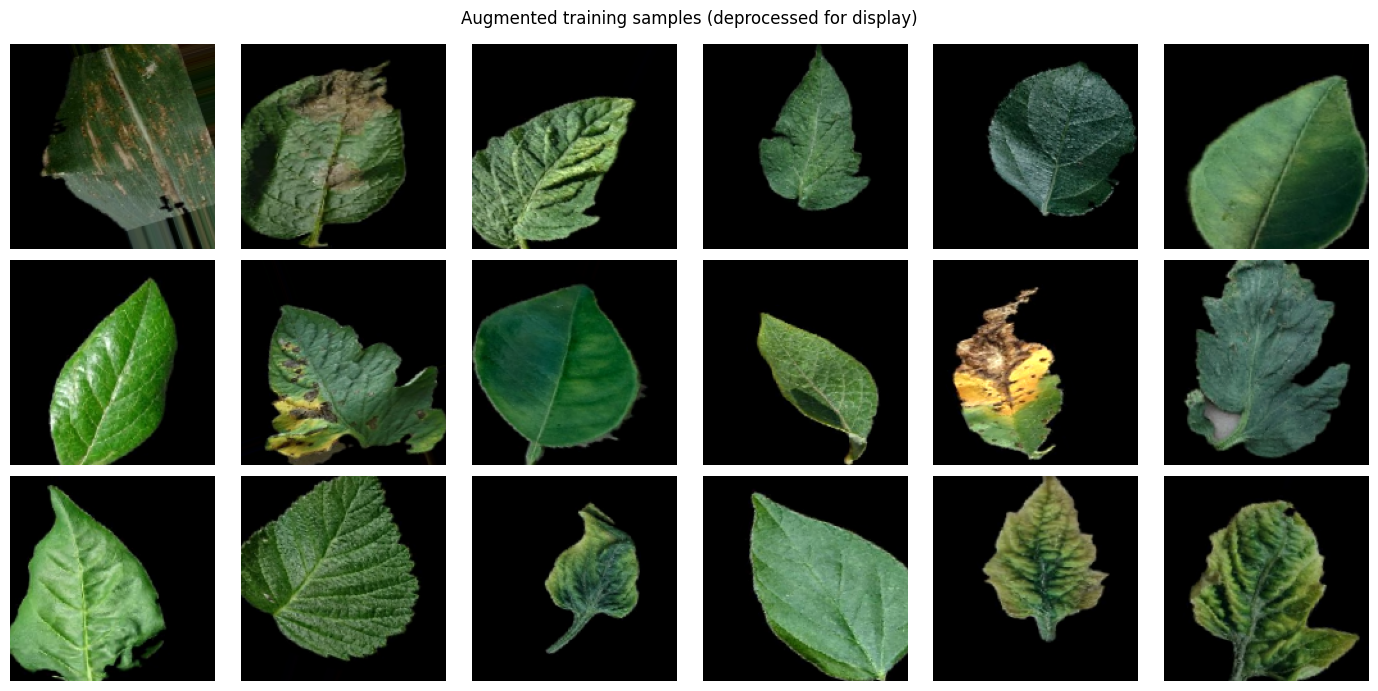

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from sklearn.utils import class_weight

# dataset root (segmented)
DATASET_ROOT = Path("/kaggle/input/plantvillage-dataset/segmented")

# parameters
img_size = 160
batch_size = 64
val_split = 0.2

# TRAIN augmentations: geometric + photometric (simulate phone shots)
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,  # correct for MobileNetV2 ImageNet
    rotation_range=25,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.15,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,     # okay for most leaf orientations
    fill_mode='nearest',
    validation_split=val_split
)

# VALIDATION: only preprocessing (no random transforms)
val_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    validation_split=val_split
)

# flow_from_directory
train_data = train_datagen.flow_from_directory(
    str(DATASET_ROOT),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    str(DATASET_ROOT),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Train samples:", train_data.samples, "Val samples:", val_data.samples)
print("Num classes:", train_data.num_classes)

# compute class weights (balanced)
y_train = train_data.classes
classes = np.unique(y_train)
cw = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {i: float(w) for i, w in enumerate(cw)}
print("Sample class weights (first 8):", dict(list(class_weights.items())[:8]))

# Visualize augmented images from one batch to sanity-check transforms
x_batch, y_batch = next(train_data)   # x_batch is preprocessed (mobilenet style)
# convert back to displayable uint8 image for plotting
# mobilenet preprocess subtracts/scales; we reverse roughly for visualization
def deprocess_mobilenet(x):
    # mobilenet preprocess: x = (x / 127.5) - 1  OR similar; safe reverse approximation:
    x = (x + 1.0) * 127.5
    x = np.clip(x, 0, 255).astype('uint8')
    return x

fig, axs = plt.subplots(3,6, figsize=(14,7))
axs = axs.ravel()
for i in range(min(18, x_batch.shape[0])):
    img = deprocess_mobilenet(x_batch[i])
    axs[i].imshow(img.astype('uint8'))
    axs[i].axis('off')
plt.suptitle("Augmented training samples (deprocessed for display)")
plt.tight_layout()
plt.show()


**7**

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
]

# Train classifier head only
history_head = model.fit(
    train_data,
    validation_data=val_data,
    epochs=8,
    callbacks=callbacks,
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8


I0000 00:00:1763142629.070281      74 service.cc:148] XLA service 0x7b1bcc005020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763142629.071388      74 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763142630.457631      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/680 ━━━━━━━━━━━━━━━━━━━━ 3:20:15 18s/step - accuracy: 0.0312 - loss: 5.4392

I0000 00:00:1763142635.850291      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.6288 - loss: 1.4775
Epoch 1: val_loss improved from inf to 0.40061, saving model to best_model.h5
680/680 ━━━━━━━━━━━━━━━━━━━━ 687s 986ms/step - accuracy: 0.6290 - loss: 1.4766 - val_accuracy: 0.8765 - val_loss: 0.4006 - learning_rate: 0.0010
Epoch 2/8
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8685 - loss: 0.4416
Epoch 2: val_loss improved from 0.40061 to 0.28400, saving model to best_model.h5
680/680 ━━━━━━━━━━━━━━━━━━━━ 453s 666ms/step - accuracy: 0.8685 - loss: 0.4416 - val_accuracy: 0.9092 - val_loss: 0.2840 - learning_rate: 0.0010
Epoch 3/8
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8841 - loss: 0.3635
Epoch 3: val_loss improved from 0.28400 to 0.26471, saving model to best_model.h5
680/680 ━━━━━━━━━━━━━━━━━━━━ 446s 656ms/step - accuracy: 0.8841 - loss: 0.3635 - val_accuracy: 0.9151 - val_loss: 0.2647 - learning_rate: 0.0010
Epoch 4/8
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8887 

**8**

In [9]:
# Unfreeze base model for fine-tuning
base_model.trainable = True

# Compile with lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    train_data,
    validation_data=val_data,
    epochs=6,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/6
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.5738 - loss: 2.6556
Epoch 1: val_loss did not improve from 0.21125
680/680 ━━━━━━━━━━━━━━━━━━━━ 561s 702ms/step - accuracy: 0.5740 - loss: 2.6538 - val_accuracy: 0.8403 - val_loss: 0.5657 - learning_rate: 1.0000e-05
Epoch 2/6
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8543 - loss: 0.4457
Epoch 2: val_loss did not improve from 0.21125
680/680 ━━━━━━━━━━━━━━━━━━━━ 438s 644ms/step - accuracy: 0.8543 - loss: 0.4456 - val_accuracy: 0.8472 - val_loss: 0.5521 - learning_rate: 1.0000e-05
Epoch 3/6
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8893 - loss: 0.3275
Epoch 3: val_loss did not improve from 0.21125
680/680 ━━━━━━━━━━━━━━━━━━━━ 440s 647ms/step - accuracy: 0.8893 - loss: 0.3275 - val_accuracy: 0.8740 - val_loss: 0.4073 - learning_rate: 1.0000e-05
Epoch 4/6
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9134 - loss: 0.2555
Epoch 4: val_loss did not improve from 0.21125
680/680 ━━━━━━━━━

**9**

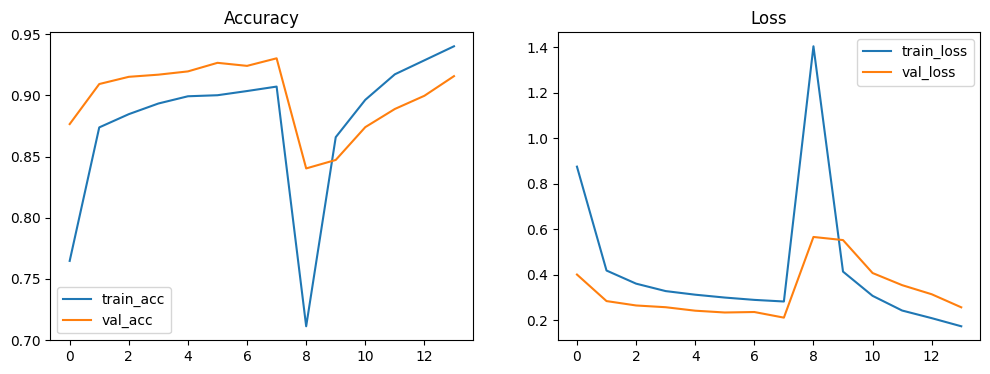

170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9496 - loss: 0.1585
Final val loss: 0.25656867027282715 val accuracy: 0.9156604409217834


In [10]:
import matplotlib.pyplot as plt
def merge(h1,h2,key):
    a = h1.history.get(key,[])
    b = h2.history.get(key,[])
    return a+b

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(merge(history_head, history_ft,'accuracy'), label='train_acc')
plt.plot(merge(history_head, history_ft,'val_accuracy'), label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(merge(history_head, history_ft,'loss'), label='train_loss')
plt.plot(merge(history_head, history_ft,'val_loss'), label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

# final evaluation
loss, acc = model.evaluate(val_data, verbose=1)
print("Final val loss:", loss, "val accuracy:", acc)


**10**

170/170 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step
Classification report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.94      0.96       126
                                 Apple___Black_rot       0.95      0.97      0.96       124
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        55
                                   Apple___healthy       0.83      0.98      0.90       329
                               Blueberry___healthy       1.00      0.96      0.98       300
          Cherry_(including_sour)___Powdery_mildew       0.99      0.95      0.97       210
                 Cherry_(including_sour)___healthy       0.98      0.97      0.98       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      0.80      0.80       102
                       Corn_(maize)___Common_rust_       0.95      0.99      0.97       238
            

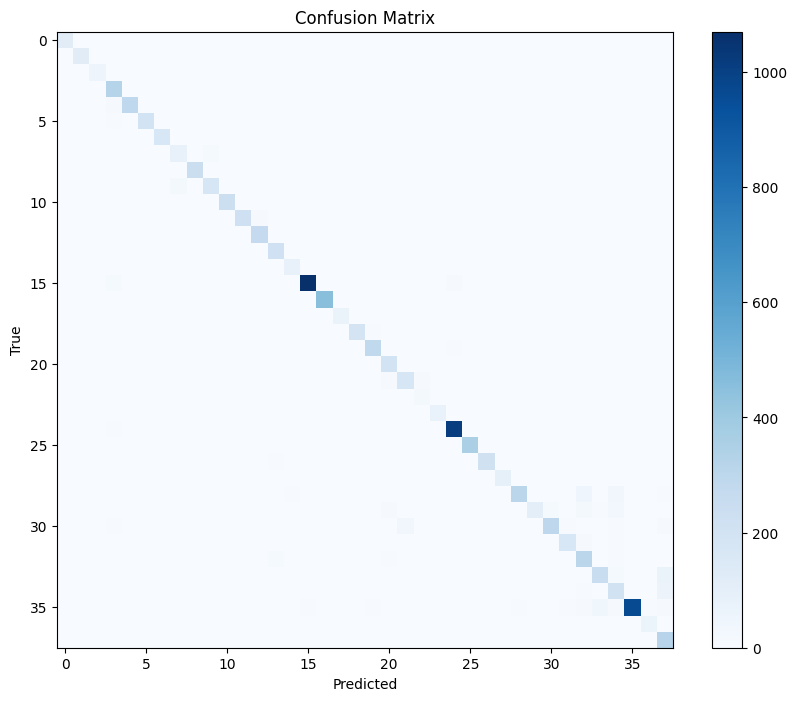

In [11]:
import numpy as np
import sklearn.metrics as skm

# predict (use steps to cover entire validation set)
steps = int(np.ceil(val_data.samples / batch_size))
preds = model.predict(val_data, steps=steps, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_data.classes

print("Classification report:")
print(skm.classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

# confusion matrix
cm = skm.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step


/tmp/ipykernel_19/3273733877.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("tab20", n_classes)


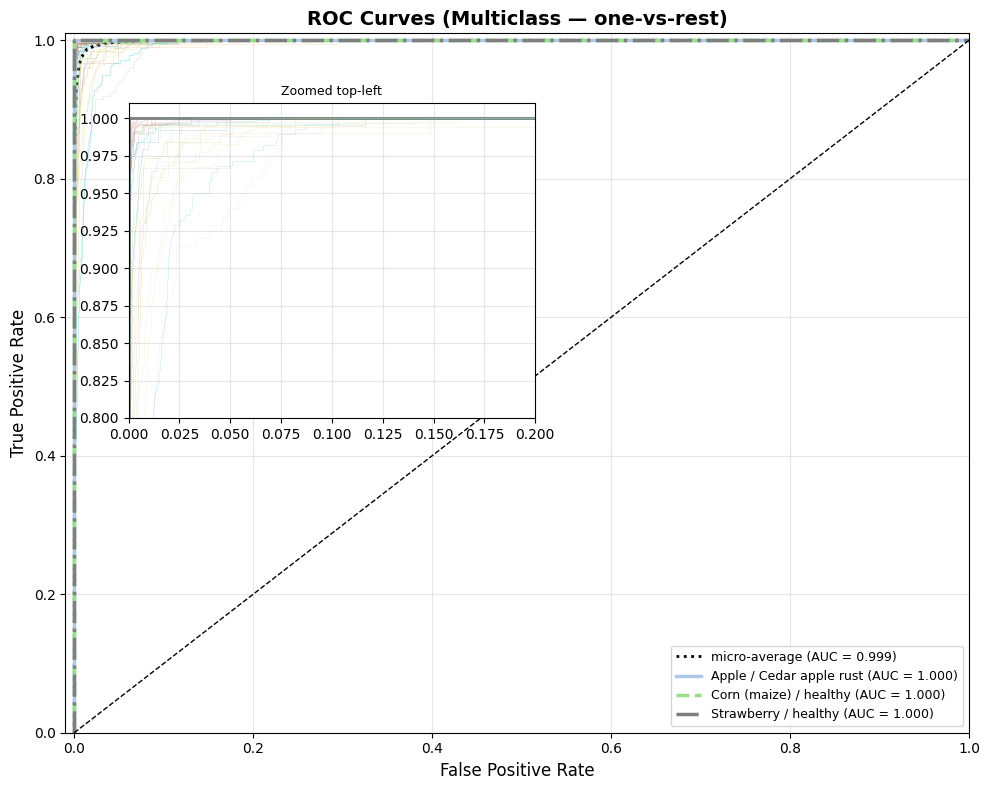

✅ Saved clearer ROC plot → /kaggle/working/roc_multiclass_clear_fixed.png
Apple / Cedar apple rust                 AUC = 1.0000
Corn (maize) / healthy                   AUC = 1.0000
Strawberry / healthy                     AUC = 1.0000


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Get predictions and binarize labels ---
steps = int(np.ceil(val_data.samples / val_data.batch_size))
y_score = model.predict(val_data, steps=steps, verbose=1)
y_true_idx = val_data.classes
n_classes = train_data.num_classes
y_test = label_binarize(y_true_idx, classes=np.arange(n_classes))

# --- Compute ROC + AUC ---
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average (overall)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Get class names ---
inv_map = {v: k for k, v in val_data.class_indices.items()}
class_names = [inv_map[i] for i in range(n_classes)]
clean_names = [c.replace("___", " / ").replace("_", " ") for c in class_names]

# --- Top-k classes by AUC ---
sorted_by_auc = sorted(range(n_classes), key=lambda i: roc_auc[i], reverse=True)
top_k = 3
top_classes = sorted_by_auc[:top_k]

# --- Colors ---
colors = cm.get_cmap("tab20", n_classes)

# --- Main Figure ---
fig, ax = plt.subplots(figsize=(10, 8))
plt.draw()  # ensures renderer exists before inset creation

ax.plot(
    fpr["micro"], tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.3f})",
    color="black", linestyle=":", linewidth=2
)

# Plot all classes faintly
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], color=colors(i), lw=0.8, alpha=0.25)

# Highlight top-3
styles = ['-', '--', '-.']
for idx, cls_idx in enumerate(top_classes):
    ax.plot(
        fpr[cls_idx], tpr[cls_idx],
        color=colors(cls_idx),
        lw=2.5, linestyle=styles[idx % len(styles)],
        label=f"{clean_names[cls_idx]} (AUC = {roc_auc[cls_idx]:.3f})"
    )

# Diagonal chance line
ax.plot([0, 1], [0, 1], 'k--', lw=1)

ax.set_xlim([-0.01, 1.0])
ax.set_ylim([0.0, 1.01])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curves (Multiclass — one-vs-rest)", fontsize=14, weight="bold")
ax.legend(loc="lower right", fontsize=9, frameon=True)
ax.grid(alpha=0.3)

# --- Inset zoom (top-left corner) ---
axins = ax.inset_axes([0.07, 0.45, 0.45, 0.45])  # [x0, y0, width, height]
for i in range(n_classes):
    if i in top_classes:
        axins.plot(fpr[i], tpr[i], color=colors(i), lw=2)
    else:
        axins.plot(fpr[i], tpr[i], color=colors(i), lw=0.5, alpha=0.2)
axins.plot([0, 1], [0, 1], 'k--', lw=0.8)
axins.set_xlim(0, 0.2)
axins.set_ylim(0.8, 1.01)
axins.grid(alpha=0.3)
axins.set_title("Zoomed top-left", fontsize=9)

plt.tight_layout()
plt.savefig("/kaggle/working/roc_multiclass_clear_fixed.png", dpi=250)
plt.show()

print("✅ Saved clearer ROC plot → /kaggle/working/roc_multiclass_clear_fixed.png")
for i in top_classes:
    print(f"{clean_names[i]:40s} AUC = {roc_auc[i]:.4f}")


**A. Utility functions**

In [13]:
# === Utilities for Explainable & Responsible AI ===
import os, io, math, random, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from skimage import segmentation
import cv2

# reverse MobileNet preprocess for visualization
def deprocess_mobilenet(x):
    # x expected in range used by mobilenet_preprocess: (x/127.5)-1 -> so reverse approx:
    x = (x + 1.0) * 127.5
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def load_image_for_model(path, target_size):
    img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
    arr = tf.keras.preprocessing.image.img_to_array(img)
    return arr

# save PNG utility
def save_figure(fig, path, dpi=180):
    fig.savefig(path, bbox_inches='tight', dpi=dpi)
    print("Saved:", path)


**B. Grad-CAM (robust version)**

In [14]:
# Robust Grad-CAM evaluation: choose true last conv layer (not BN), resize heatmap to image size
import numpy as np, cv2, os, pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import cm

# 1) Find last true conv-like layer (prefer Conv2D/DepthwiseConv/SeparableConv)
conv_candidates = []
for i, layer in enumerate(model.layers):
    cls = layer.__class__.__name__.lower()
    lname = layer.name.lower()
    # consider actual conv types (exclude batchnorm, relu, etc.)
    if any(x in cls for x in ['conv2d','depthwiseconv2d','separableconv']) or 'conv' in lname and 'bn' not in lname:
        try:
            shp = layer.output.shape
            if len(shp) == 4:
                conv_candidates.append((i, layer.name))
        except Exception:
            pass

# fallback: include others if empty
if len(conv_candidates) == 0:
    for i, layer in enumerate(model.layers):
        lname = layer.name.lower()
        try:
            shp = layer.output.shape
            if len(shp) == 4:
                conv_candidates.append((i, layer.name))
        except Exception:
            pass

if len(conv_candidates) == 0:
    raise RuntimeError("No conv-like layers found in model.")

last_conv_idx, last_conv_name = conv_candidates[-1]
print("Selected conv layer for Grad-CAM:", last_conv_name, " (index", last_conv_idx, ")")

# 2) Define safe gradcam function and overlay (resizes heatmap to image)
import tensorflow as tf

def gradcam_heatmap_resized(model, img_array, layer_name, out_size):
    """
    Returns heatmap resized to out_size (H,W) and predicted class idx.
    """
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap.numpy()
    # normalize and resize to out_size
    if np.max(heatmap) > 0:
        heatmap = heatmap / (np.max(heatmap) + 1e-8)
    heatmap_resized = cv2.resize((heatmap*255).astype('uint8'), (out_size[1], out_size[0]))
    heatmap_resized = heatmap_resized.astype('float32')/255.0
    return heatmap_resized, int(pred_index)

def overlay_heatmap_on_rgb(orig_uint8, heatmap, alpha=0.45, cmap='jet'):
    # heatmap must already be same HxW as orig_uint8
    col = cm.get_cmap(cmap)(np.uint8(heatmap*255)/255.0)[...,:3] * 255
    over = cv2.addWeighted(orig_uint8, 1.0, col.astype('uint8'), alpha, 0)
    return over

# 3) pseudo-mask function (segmented images likely have leaf; tune threshold if needed)
def create_pseudo_mask(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    _, m = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    return (m>0).astype('uint8')

# 4) pointing game & IoU using resized heatmap
def pointing_game_and_iou_resized(heatmap_resized, mask, top_percent=0.1):
    thr = np.percentile(heatmap_resized, 100*(1-top_percent))
    pred_mask = (heatmap_resized >= thr).astype('uint8')
    inter = np.logical_and(pred_mask, mask).sum()
    union = np.logical_or(pred_mask, mask).sum()
    iou = inter / (union + 1e-8)
    peak = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)
    hit = bool(mask[peak[0], peak[1]] > 0)
    return hit, iou, pred_mask

# 5) iterate over validation set, compute metrics, save examples
filepaths = val_data.filepaths
N = min(500, len(filepaths))   # limit for speed; increase if desired
out_dir = "/kaggle/working/gradcam_eval_resized"
os.makedirs(out_dir, exist_ok=True)

results = []
skipped = 0
for i, fp in enumerate(filepaths[:N]):
    try:
        img = load_img(fp, target_size=(img_size, img_size))
        raw_arr = img_to_array(img).astype('uint8')
        mask = create_pseudo_mask(raw_arr)
        x = np.expand_dims(mobilenet_preprocess(img_to_array(img).astype('float32')), axis=0)
        heat_resized, pred = gradcam_heatmap_resized(model, x, last_conv_name, out_size=(img_size, img_size))
        hit, iou, pred_mask = pointing_game_and_iou_resized(heat_resized, mask, top_percent=0.10)
        results.append({'index': i, 'filepath': fp, 'pred': int(pred), 'hit': int(hit), 'iou': float(iou)})
        if i < 30:  # save first 30 overlays and pred masks
            ov = overlay_heatmap_on_rgb(raw_arr, heat_resized, alpha=0.45)
            cv2.imwrite(os.path.join(out_dir, f"overlay_{i}_pred{pred}.png"), cv2.cvtColor(ov, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(out_dir, f"predmask_{i}.png"), (pred_mask*255).astype('uint8'))
    except Exception as e:
        skipped += 1
        # optional: print small informative message occasionally
        if skipped <= 10:
            print("Skipping", fp, "due to error:", e)
        continue

# 6) summary
import pandas as pd
df = pd.DataFrame(results)
mean_hit = df['hit'].mean() if not df.empty else 0.0
mean_iou = df['iou'].mean() if not df.empty else 0.0
print(f"Processed {len(df)} images, skipped {skipped}. Pointing-game hit rate = {mean_hit:.4f}, mean IoU = {mean_iou:.4f}")
csv_path = os.path.join(out_dir, "gradcam_pointing_iou_resized.csv")
df.to_csv(csv_path, index=False)
print("Saved CSV and example overlays to", out_dir)


Selected conv layer for Grad-CAM: Conv_1  (index 151 )


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 160, 160, 3))
  warnings.warn(msg)
/tmp/ipykernel_19/1800316211.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  col = cm.get_cmap(cmap)(np.uint8(heatmap*255)/255.0)[...,:3] * 255


Processed 500 images, skipped 0. Pointing-game hit rate = 0.8400, mean IoU = 0.1990
Saved CSV and example overlays to /kaggle/working/gradcam_eval_resized


**C. LIME (image)**

  0%|          | 0/150 [00:00<?, ?it/s]

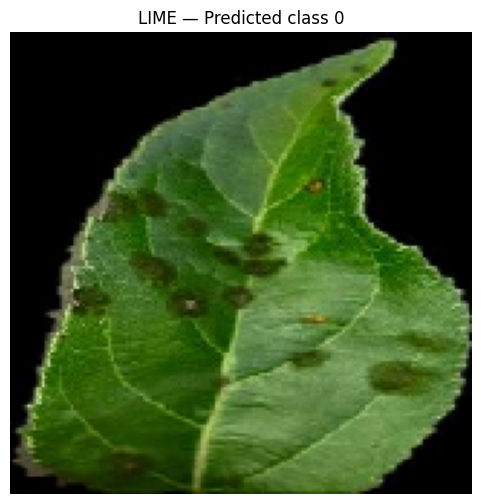

In [15]:
!pip install -q lime
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# LIME wrapper prediction function
def lime_predict(imgs_uint8):
    arr = np.array([mobilenet_preprocess(img.astype('float32')) 
                    for img in imgs_uint8])
    preds = model.predict(arr, verbose=0)
    return preds

def run_lime_explanation(img_path, num_samples=150):
    img_pil = load_img(img_path, target_size=(img_size, img_size))
    img_arr = img_to_array(img_pil).astype("uint8")

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_arr,
        classifier_fn=lime_predict,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )

    label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.figure(figsize=(6,6))
    plt.imshow(temp.astype("uint8"))
    plt.title(f"LIME — Predicted class {label}")
    plt.axis("off")
    plt.show()

# TEST
run_lime_explanation(val_data.filepaths[1])


**D. SHAP (DeepExplainer) — feature attribution**

In [16]:
# Robust PCA + Kernel SHAP (safe n_components selection)
import numpy as np
from sklearn.decomposition import PCA
import shap, pickle, os, math
from sklearn.exceptions import NotFittedError

# bg_feats (n_bg, feat_dim) and val_feats (m, feat_dim) come from previous runs
n_bg, feat_dim = bg_feats.shape
print("Background samples:", n_bg, "Feature dim:", feat_dim)

# choose safe n_components: <= n_bg-1 and <= feat_dim
preferred = 20
n_components = min(preferred, n_bg - 1, feat_dim)
if n_components < 5:
    n_components = max(2, n_bg - 1)  # fall back to at least 2 if extremely small

print(f"Using n_components = {n_components} for PCA (must be <= n_bg-1).")

# fit PCA (with try/except to fallback to smaller n_components if needed)
success = False
while not success and n_components >= 2:
    try:
        pca = PCA(n_components=n_components, whiten=False, random_state=42)
        pca.fit(bg_feats)
        success = True
    except Exception as e:
        print("PCA fit failed for n_components =", n_components, "error:", e)
        n_components = max(2, n_components - 5)  # reduce and retry
        print("Retrying with n_components =", n_components)

if not success:
    raise RuntimeError("PCA failed for all tested n_components. Cannot continue with Kernel SHAP on PCA.")

bg_pca = pca.transform(bg_feats)
val_pca = pca.transform(val_feats)
print("bg_pca shape:", bg_pca.shape, "val_pca shape:", val_pca.shape)

# prediction function mapping PCA-feats -> probs via inverse transform -> final dense
def predict_from_pca_feats(pca_feats):
    orig_feats = pca.inverse_transform(pca_feats)   # -> (m, feat_dim)
    logits = np.dot(orig_feats, W) + b
    ex = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = ex / np.sum(ex, axis=1, keepdims=True)
    return probs

print("Initializing KernelExplainer (may take a short while)...")
explainer = shap.KernelExplainer(predict_from_pca_feats, bg_pca)

nsamples = 200  # keep small for speed; increase if you want more stable SHAP
print(f"Computing SHAP values on {val_pca.shape[0]} sample(s) with nsamples={nsamples} ...")
shap_vals_pca = explainer.shap_values(val_pca, nsamples=nsamples)  # list per class

# Map SHAP PCA contributions back to original feature space
components = pca.components_  # shape (n_components, feat_dim)
shap_vals_mapped = []
for c in range(len(shap_vals_pca)):
    arr = np.array(shap_vals_pca[c])   # (m, n_components)
    mapped = np.dot(arr, components)    # (m, feat_dim)
    shap_vals_mapped.append(mapped)
shap_vals_mapped = np.array(shap_vals_mapped)  # (n_classes, m, feat_dim)
print("Mapped SHAP shape:", shap_vals_mapped.shape)

# Print top-10 original feature indices per sample for predicted class
pred_probs = predict_from_pca_feats(val_pca)
pred_classes = np.argmax(pred_probs, axis=1)
print("Predicted classes for val samples:", pred_classes)

for si in range(val_feats.shape[0]):
    cls = int(pred_classes[si])
    vals = np.abs(shap_vals_mapped[cls, si])   # (feat_dim,)
    topk = np.argsort(vals)[-10:][::-1]
    print(f"\nSample {si} predicted class {cls} top-10 original feature indices (abs shap):")
    for rank, idx in enumerate(topk, start=1):
        print(f"  {rank:2d}. feature_idx={idx:4d}   importance={vals[idx]:.6f}")

# Save mapped SHAP results for reuse
outp = "/kaggle/working/shap_mapped_pca_safe.npz"
np.savez_compressed(outp, shap_vals_mapped=shap_vals_mapped, pred_classes=pred_classes, val_feats=val_feats, bg_feats=bg_feats, pca_components=components)
print("Saved shap mapped file to:", outp)


NameError: name 'bg_feats' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# pick sample index (0,1,2)
sample_id = 0
cls = pred_classes[sample_id]
vals = np.abs(shap_vals_mapped[cls, sample_id])

topk = np.argsort(vals)[-10:][::-1]

plt.figure(figsize=(10,5))
plt.bar(range(10), vals[topk])
plt.xticks(range(10), topk, rotation=45)
plt.title(f"Top-10 SHAP Feature Importances (Sample {sample_id}, Class {cls})")
plt.ylabel("Absolute SHAP Value")
plt.xlabel("Feature Index")
plt.show()


**MC-Dropout Uncertainty across validation set + abstention (coverage vs accuracy)**

In [ ]:
# MC-Dropout evaluation and abstention curve
import numpy as np, math, pandas as pd
from tqdm import tqdm

def mc_dropout_predict_mean_std(model, x, T=25):
    preds = []
    for _ in range(T):
        preds.append(model(x, training=True).numpy())
    preds = np.array(preds)  # (T, batch, classes)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std

# iterate over validation set in batches and collect mean probs, std metrics, true labels
batch_size = val_data.batch_size
steps = int(math.ceil(val_data.samples / batch_size))
all_means = []
all_stds = []
y_true = []

print("Running MC dropout across validation set (may take a few minutes)...")
for xb, yb in tqdm(val_data, total=steps):
    mean, std = mc_dropout_predict_mean_std(model, xb, T=20)  # T=20 for speed
    all_means.append(mean)
    all_stds.append(std)
    y_true.append(np.argmax(yb, axis=1))
    if len(all_means)*batch_size >= val_data.samples:
        break

probs = np.vstack(all_means)[:val_data.samples]
stds = np.vstack(all_stds)[:val_data.samples]
y_true = np.concatenate(y_true)[:val_data.samples]
preds_mean = probs.argmax(axis=1)
pred_uncertainty = stds.max(axis=1)  # use max class std as uncertainty score

print("Collected", len(preds_mean), "predictions.")

# Abstention analysis: sort by uncertainty, drop top-k uncertain and compute accuracy
indices = np.argsort(pred_uncertainty)  # low->high
coverages = np.linspace(0.1, 1.0, 10)   # fraction of samples to keep (coverage)
results = []
for cov in coverages:
    keep = int(cov * len(indices))
    keep_idx = indices[:keep]
    acc = (preds_mean[keep_idx] == y_true[keep_idx]).mean() if keep>0 else 0.0
    avg_unc = pred_uncertainty[keep_idx].mean() if keep>0 else np.nan
    results.append({'coverage': cov, 'accuracy': float(acc), 'mean_uncertainty_kept': float(avg_unc)})

df_abstain = pd.DataFrame(results)
print(df_abstain)
df_abstain.to_csv("/kaggle/working/mc_dropout_abstention.csv", index=False)
print("Saved abstention curve to /kaggle/working/mc_dropout_abstention.csv")


**Temperature scaling (optimize T) + ECE & reliability plot**

In [ ]:
# Temperature scaling and ECE (Expected Calibration Error) plot
!pip install -q netcal
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import minimize
import sklearn.metrics as skm
from netcal.metrics import ECE

# collect probs and labels (use model.predict on val_data)
batch_size = val_data.batch_size
steps = int(math.ceil(val_data.samples / batch_size))
probs = []
labels = []
for xb, yb in val_data:
    probs.append(model.predict(xb, verbose=0))
    labels.append(np.argmax(yb, axis=1))
    if len(probs)*batch_size >= val_data.samples:
        break
probs = np.vstack(probs)[:val_data.samples]
labels = np.concatenate(labels)[:val_data.samples]

# ECE helper
def compute_ece(probs, labels, n_bins=15):
    ece = ECE(bins=n_bins)
    return float(ece.measure(probs, labels))

print("ECE before:", compute_ece(probs, labels))

# learn temperature by minimizing NLL on val set (probs -> logits approx)
logits = np.log(np.clip(probs, 1e-12, 1.0))
def nll_temp_scalar(T):
    T=float(T)
    scaled = logits / T
    exp = np.exp(scaled - np.max(scaled, axis=1, keepdims=True))
    p = exp / exp.sum(axis=1, keepdims=True)
    nll = -np.mean(np.log(np.clip(p[np.arange(len(p)), labels], 1e-12,1.0)))
    return nll

res = minimize(lambda x: nll_temp_scalar(x), x0=[1.0], bounds=[(0.05, 10.0)])
T_opt = float(res.x[0])
print("Optimal temperature:", T_opt)

# apply temperature to probs
def apply_temperature(probs, T):
    logits = np.log(np.clip(probs, 1e-12,1.0))
    scaled = logits / T
    exp = np.exp(scaled - np.max(scaled, axis=1, keepdims=True))
    p = exp / exp.sum(axis=1, keepdims=True)
    return p

probs_scaled = apply_temperature(probs, T_opt)
print("ECE after:", compute_ece(probs_scaled, labels))

# Reliability (calibration) plot before/after
def reliability_plot(probs, labels, n_bins=15, title="Reliability Plot"):
    bin_edges = np.linspace(0,1,n_bins+1)
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accs = (predictions == labels).astype(int)
    bin_centers, bin_acc, bin_conf = [], [], []
    for i in range(n_bins):
        lo, hi = bin_edges[i], bin_edges[i+1]
        mask = (confidences >= lo) & (confidences < hi)
        if np.any(mask):
            bin_centers.append((lo+hi)/2)
            bin_acc.append(accs[mask].mean())
            bin_conf.append(confidences[mask].mean())
    plt.plot([0,1],[0,1],"k--", linewidth=1, alpha=0.5)
    plt.plot(bin_centers, bin_acc, marker='o', label='Accuracy')
    plt.plot(bin_centers, bin_conf, marker='x', label='Confidence')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
reliability_plot(probs, labels, title="Before Temperature Scaling")
plt.subplot(1,2,2)
reliability_plot(probs_scaled, labels, title=f"After Temperature Scaling (T={T_opt:.3f})")
plt.tight_layout()
plt.savefig("/kaggle/working/reliability_plots.png", dpi=200)
print("Saved reliability plots to /kaggle/working/reliability_plots.png")


**Robustness tests (per-image summary, saves CSV)**

In [ ]:
# Robustness tests: noise, brightness, jpeg on small subset and measure accuracy drop and IoU change
import random, numpy as np, cv2, pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

OUT = "/kaggle/working/robustness"
os.makedirs(OUT, exist_ok=True)

def perturb_image(img_uint8, mode):
    img = img_uint8.copy()
    if mode == 'noise':
        img = np.clip(img + np.random.normal(0,12,img.shape), 0,255).astype('uint8')
    elif mode == 'bright':
        f = random.uniform(0.7,1.3)
        img = np.clip(img * f, 0,255).astype('uint8')
    elif mode == 'jpeg':
        q = random.randint(20,60)
        _, enc = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), q])
        img = cv2.imdecode(enc, cv2.IMREAD_COLOR)
    return img

def eval_on_subset(n=200):
    sample_paths = random.sample(val_data.filepaths, min(n, len(val_data.filepaths)))
    rows=[]
    for p in sample_paths:
        img = load_img(p, target_size=(img_size,img_size))
        img_arr = img_to_array(img).astype('uint8')
        x = np.expand_dims(mobilenet_preprocess(img_to_array(img).astype('float32')),0)
        orig_prob = model.predict(x, verbose=0)[0]
        orig_pred = np.argmax(orig_prob)
        # gradcam orig
        heat_orig, _ = gradcam_heatmap_resized(model, x, last_conv_name, out_size=(img_size,img_size))
        mask = (cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY) > 10).astype('uint8')
        _, iou_orig_predmask = pointing_game_and_iou_resized(heat_orig, mask, top_percent=0.1)[0:2]  # reuse function

        for mode in ['noise','bright','jpeg']:
            pert = perturb_image(img_arr, mode)
            xp = np.expand_dims(mobilenet_preprocess(pert.astype('float32')),0)
            probp = model.predict(xp, verbose=0)[0]
            predp = np.argmax(probp)
            changed = int(predp != orig_pred)
            # gradcam perturbed
            heat_p, _ = gradcam_heatmap_resized(model, xp, last_conv_name, out_size=(img_size,img_size))
            # IoU between top10% masks
            thr_o = np.percentile(heat_orig, 90)
            thr_p = np.percentile(heat_p, 90)
            mask_o = (heat_orig >= thr_o).astype('uint8')
            mask_p = (heat_p >= thr_p).astype('uint8')
            inter = np.logical_and(mask_o, mask_p).sum()
            union = np.logical_or(mask_o, mask_p).sum()
            iou_change = inter / (union+1e-8)
            rows.append({'path':p, 'mode':mode, 'orig_pred':int(orig_pred), 'pert_pred':int(predp), 'pred_changed':changed, 'iou_overlap':float(iou_change)})
    return pd.DataFrame(rows)

df_rob = eval_on_subset(n=200)
df_rob.to_csv(os.path.join(OUT, "robustness_summary.csv"), index=False)
print("Saved robustness summary to", OUT)
print(df_rob.groupby('mode')['pred_changed'].mean())
print("Mean IoU overlap per mode:")
print(df_rob.groupby('mode')['iou_overlap'].mean())
